# Predicción de tarifas de Uber

El proyecto está basado en un dataset con datos de viajes de Uber, compañía líder en servicios de movilidad alrededor del mundo.
Una de las problemáticas principales es cómo cotizan el valor del viaje en tiempo real, basado en información en tiempo real sobre la oferta y demanda, distancia del viaje, datos históricos y cantidad de pasajeros en menor medida.

El desafío es armar un modelo de predicción de tarifas ya que creemos que esta información es de gran relevancia para el negocio, es un dato clave para el cliente a la hora de tomar la decisión de contratar el servicio.
El análisis estará basado en los datos proporcionados que son los siguientes:

1. Key: identificador de cada viaje

2. fare_amount: tarifa del viaje

3. pickup_datetime: hora y fecha del inicio del viaje

4. pickup_longitude: longitud en el mapa sobre el punto de recogida

5. pickup_latitude: latidud en el mapa sobre el punto de recogida

6. dropoff_longitude: longitud del punto final del viaje

7. dropoff_latitude: latitud del punto final del viaje

8. passenger_count: cantidad de pasajeros


El dataset fue obtenido de Kaggle.
Se realizó una limpieza inicial donde se eliminó una columna que no servía para el análisis.

Obviamente no contaremos con información en tiempo real sobre oferta y demanda, pero tal vez sí podremos estimar demanda combinando datos de horario y pickup.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from seaborn import boxplot
from seaborn import countplot
from seaborn import distplot
from geopy.geocoders import ArcGIS
from geopy.distance import geodesic
from geopy.geocoders import Nominatim
from haversine import haversine
import matplotlib.pyplot as plt
from seaborn import heatmap
geolocator = Nominatim(user_agent="geoapiExercises")
from datetime import *
from mpl_toolkits.basemap import Basemap
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
import lightgbm as lgb
from lightgbm import LGBMRegressor
import sklearn

### Importo el Dataset

In [2]:
df=pd.read_csv("https://raw.githubusercontent.com/ezequielimeneses/TrabajoFinalDatascientistCoder/9ce01a9d9600daddcd290ab33e5988ebaaf9f6b0/uber.csv")


### Verifico que se haya cargado bien el dataset

In [3]:
df.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


### Miro datos básicos de cada columna

In [4]:
df.shape

(200000, 9)

In [5]:
df.count()

Unnamed: 0           200000
key                  200000
fare_amount          200000
pickup_datetime      200000
pickup_longitude     200000
pickup_latitude      200000
dropoff_longitude    199999
dropoff_latitude     199999
passenger_count      200000
dtype: int64

In [6]:
df.describe()

,Unnamed: 0,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,2.000000e+05,200000.000000,200000.000000,200000.000000,199999.000000,199999.000000,200000.000000
mean,2.771250e+07,11.359955,-72.527638,39.935885,-72.525292,39.923890,1.684535
std,1.601382e+07,9.901776,11.437787,7.720539,13.117408,6.794829,1.385997
min,1.000000e+00,-52.000000,-1340.648410,-74.015515,-3356.666300,-881.985513,0.000000
25%,1.382535e+07,6.000000,-73.992065,40.734796,-73.991407,40.733823,1.000000
50%,2.774550e+07,8.500000,-73.981823,40.752592,-73.980093,40.753042,1.000000
75%,4.155530e+07,12.500000,-73.967154,40.767158,-73.963658,40.768001,2.000000
max,5.542357e+07,499.000000,57.418457,1644.421482,1153.572603,872.697628,208.000000


La primer conclusión es que tengo las dos variables numéricas ( cantidad de pasajeros y tarifas) y el resto son variables categóricas (latitud y longitud del comienzo y fin de cada viaje). También está la columna date time con la fecha y hora de comienzo del viaje

Se tienen entonces 7 columnas con 199.996 registros (viajes) 

### Elimino la primer columna que no suma para el análisis

In [7]:
df=df.iloc[:,1:]
df

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5
...,...,...,...,...,...,...,...,...
199995,2012-10-28 10:49:00.00000053,3.0,2012-10-28 10:49:00 UTC,-73.987042,40.739367,-73.986525,40.740297,1
199996,2014-03-14 01:09:00.0000008,7.5,2014-03-14 01:09:00 UTC,-73.984722,40.736837,-74.006672,40.739620,1
199997,2009-06-29 00:42:00.00000078,30.9,2009-06-29 00:42:00 UTC,-73.986017,40.756487,-73.858957,40.692588,2
199998,2015-05-20 14:56:25.0000004,14.5,2015-05-20 14:56:25 UTC,-73.997124,40.725452,-73.983215,40.695415,1


## Ejemplos Análisis univariado 

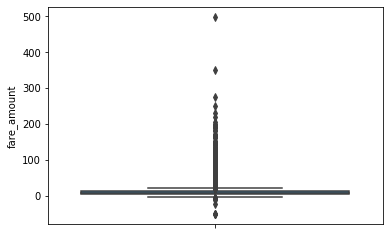

In [8]:
boxplot(df.fare_amount, orient="v",width=0.8,fliersize=5)

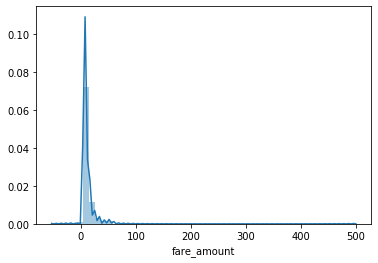

In [9]:
distplot(df.fare_amount)

Cómo se ve gráficamente, hay una dispersión muy grande en los datos. Para hacer un análisis mejor podría quedarme con los registros con tarifa menor a 100 (considerando que estos son los signifactivos)

In [10]:
tarifas_entre0y100=(df.fare_amount<100)&(df.fare_amount>0)

In [11]:
tarifas_entre0y100

0         True
1         True
2         True
3         True
4         True
          ... 
199995    True
199996    True
199997    True
199998    True
199999    True
Name: fare_amount, Length: 200000, dtype: bool

In [12]:
df_tarifas_menores_a_100=df[tarifas_entre0y100]
df_tarifas_menores_a_100.shape

(199888, 8)

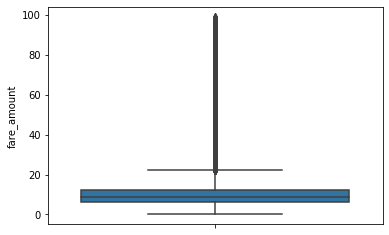

In [13]:
boxplot(df_tarifas_menores_a_100.fare_amount,orient="v")

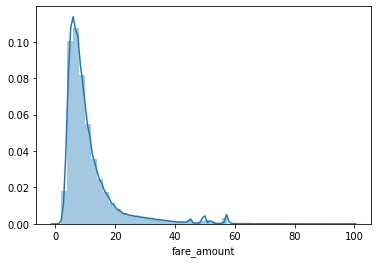

In [14]:
distplot(df_tarifas_menores_a_100.fare_amount)

Perdiendo pocos registros, 111 (0,05% del total inicial), se puede observar mucho mejor la información y hacer un análisis más valioso. Igualmente se sigue viendo, que dentro de ese rango, los datos se encuentran dispersos ya que la frecuencia máxima es un poco más del 10%.

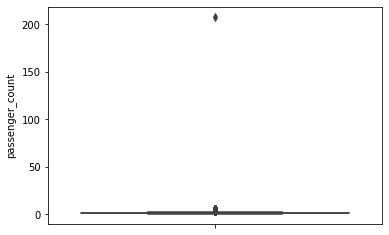

In [15]:
boxplot(df.passenger_count,orient="v")

Lo mismo podemos hacer con esta columna y eliminar el outlier de 200 pasajeros (que no tiene sentido lógico)

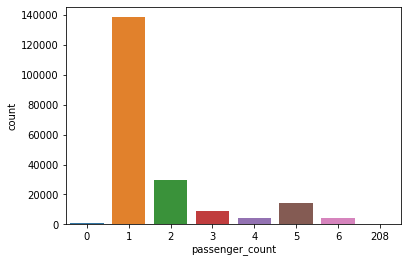

In [16]:
countplot(df.passenger_count)

In [17]:
pasajeros = df.passenger_count<=6

In [18]:
df_sin_208_pasajeros=df[pasajeros]

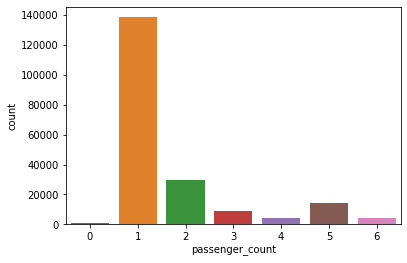

In [19]:
countplot(df_sin_208_pasajeros.passenger_count)

In [20]:
frecuencia_cuenta_pasajeros=df_sin_208_pasajeros.passenger_count.value_counts()
frecuencia_cuenta_pasajeros

1    138425
2     29428
5     14009
3      8881
4      4276
6      4271
0       709
Name: passenger_count, dtype: int64

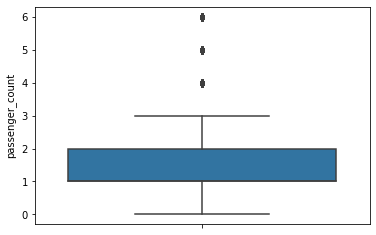

In [21]:
boxplot(df_sin_208_pasajeros.passenger_count,orient="v")

Como vemos, la gran cantidad de viajes fueron con un pasajero. Podemos ver, como tiene sentido, que los viajes fueron desde 1 a 6 pasajeros y habría que seguir averiguando (con el dueño del dataset si esto fuera posible) a que se debe esa cantidad de viajes con 0 pasajeros para ver si se podrían eliminar para no ensuciar la información. 

## Ejemplo Análisis Bivariado 

### Para empezar, planteo dos escenarios que quiero analizar de forma bivariada:
    * Cantidad de pasajeros como variable independiente y tarifa como dependiente
    * Distancia como variable independiente y tarifa como dependiente

#### Genero la distancia haversine entre salida y llegada de cada viaje  

In [22]:
index= df.index
index
distancia=[]
for i in range(len(index)):
    punto_salida=df.pickup_latitude[i],df.pickup_longitude[i]
    punto_llegada=df.dropoff_latitude[i],df.dropoff_longitude[i]
    distancia_viaje=haversine(punto_salida,punto_llegada)
    distancia.append(distancia_viaje)
    distancia

In [23]:
df["distancia_viaje_en_km"]=distancia

In [24]:
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distancia_viaje_en_km
0,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1,1.683325
1,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1,2.457593
2,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1,5.036384
3,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3,1.661686
4,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5,4.475456


Text(0.5, 1, 'HeatMap con todas las columnas')

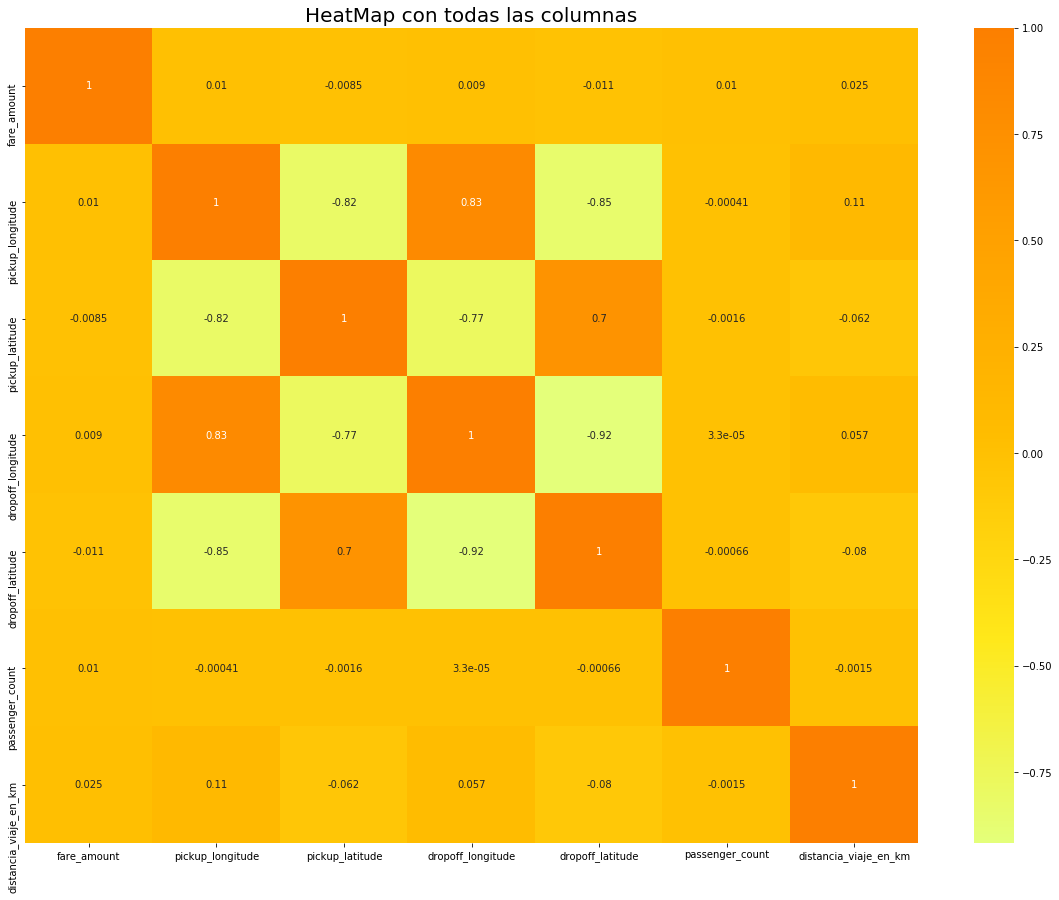

In [25]:
%matplotlib inline
plt.rcParams["figure.figsize"]=(20,15)
sns.heatmap(df.corr(),annot=True,cmap="Wistia")
plt.title("HeatMap con todas las columnas", fontsize=20)

### Me quedo unicamente con las columnas de interes para hacer el mapa de calor 

In [26]:
df.columns.values.tolist()

['key',
 'fare_amount',
 'pickup_datetime',
 'pickup_longitude',
 'pickup_latitude',
 'dropoff_longitude',
 'dropoff_latitude',
 'passenger_count',
 'distancia_viaje_en_km']

In [27]:
columnas_interes=["fare_amount","passenger_count","distancia_viaje_en_km"]
df_columnas_interes=df[columnas_interes]

### Verifico que me haya quedado correcto el nuevo DF 

In [28]:
df_columnas_interes.head()

,fare_amount,passenger_count,distancia_viaje_en_km
0,7.5,1,1.683325
1,7.7,1,2.457593
2,12.9,1,5.036384
3,5.3,3,1.661686
4,16.0,5,4.475456


Text(0.5, 1, 'HeatMap únicamente con columnas de interés')

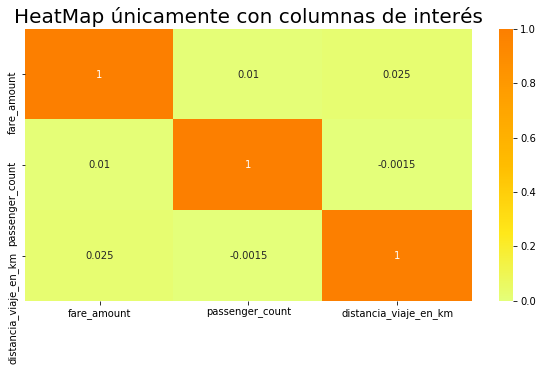

In [29]:
%matplotlib inline
plt.rcParams["figure.figsize"]=(10,5)
sns.heatmap(df_columnas_interes.corr(),annot=True,cmap="Wistia")
plt.title("HeatMap únicamente con columnas de interés", fontsize=20)

No pareciera existir una relación lineal fuerte entre estas variables 

## Hago análisis gráficamente entre las dos situaciones planteadas
    

### Tarifa vs Distancia

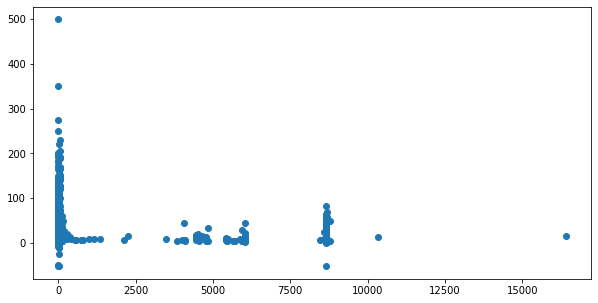

In [30]:
plt.scatter(df_columnas_interes.distancia_viaje_en_km,df_columnas_interes.fare_amount)

Gráficamente se ven valores extraños en la distancia. Busco encontrar la magnitud de estos valores y frecuencia con un histograma

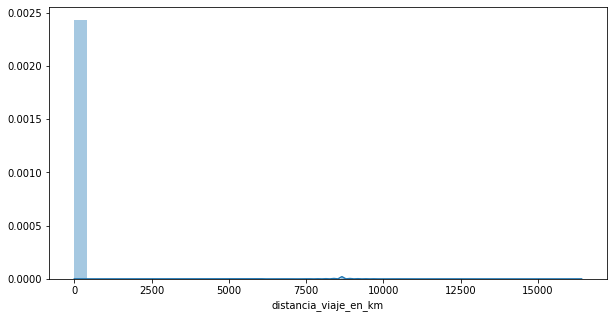

In [31]:
distplot(df_columnas_interes.distancia_viaje_en_km,bins=40)

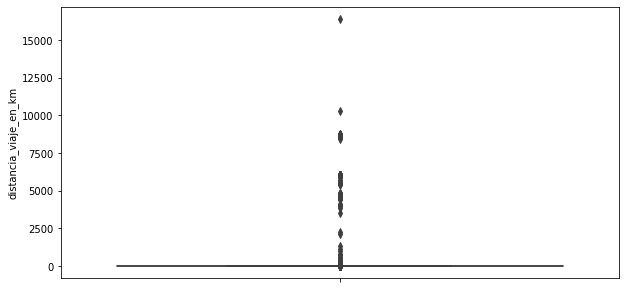

In [32]:
boxplot(df_columnas_interes.distancia_viaje_en_km, orient="v")

Verifico con distancias menor a 2000 km

In [33]:
df_distancias_menores_a_2000km=df_columnas_interes[df_columnas_interes["distancia_viaje_en_km"]<2000]

In [34]:
df_tarifas_menores_a_100.shape

(199888, 8)

Eliminé muy pocos registros, por lo que lo veo correcto e intento gráficar de nuevo.

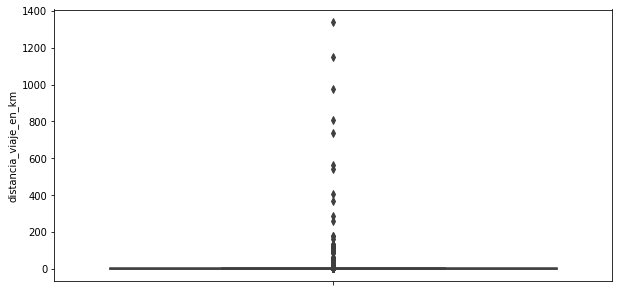

In [35]:
boxplot(df_distancias_menores_a_2000km.distancia_viaje_en_km, orient="v")

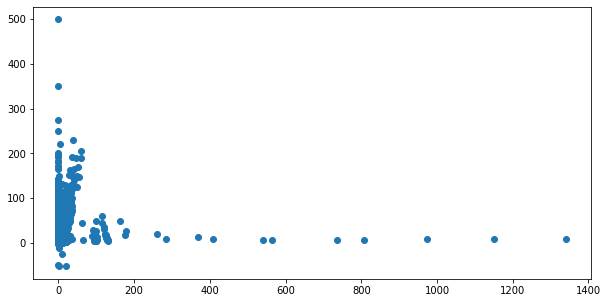

In [36]:
plt.scatter(df_distancias_menores_a_2000km.distancia_viaje_en_km,df_distancias_menores_a_2000km.fare_amount)

Intento haciendo un corte en 200 km

In [37]:
df_distancias_menores_a_200km=df_columnas_interes[df_columnas_interes["distancia_viaje_en_km"]<200]

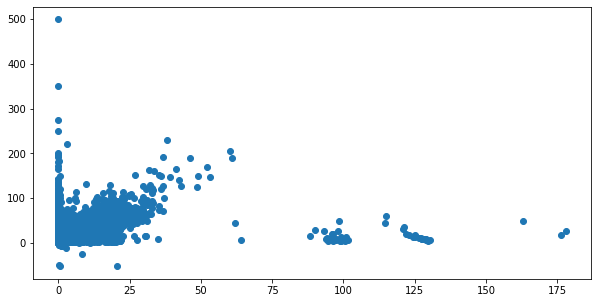

In [38]:
plt.scatter(df_distancias_menores_a_200km.distancia_viaje_en_km,df_distancias_menores_a_200km.fare_amount)

Logro que tenga más sentido pero igualmente, como se había visto en el heatmap, no hay relación lineal entre ambos conceptos.

### Tarifa vs Cantidad de pasajeros

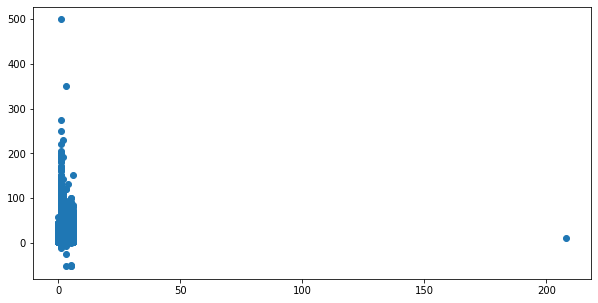

In [39]:
plt.scatter(df_columnas_interes.passenger_count,df_columnas_interes.fare_amount)

Utilizo el DF dónde ya habíamos eliminado el outlier

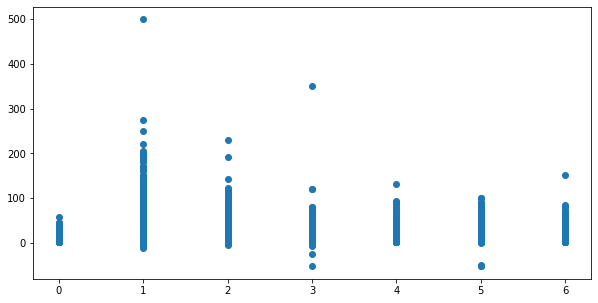

In [40]:
plt.scatter(df_sin_208_pasajeros.passenger_count,df_sin_208_pasajeros.fare_amount)

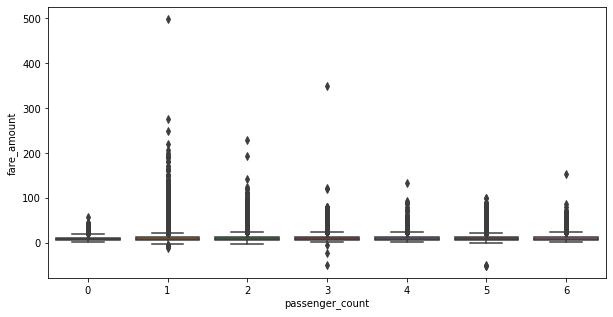

In [41]:
boxplot(x=df_sin_208_pasajeros.passenger_count,y=df_sin_208_pasajeros.fare_amount)

Para ver si tiene más sentido, voy a hacer una tarifa por km (TARIFA/DISTANCIA) y eliminar los outliers de ese dataset

In [42]:
index2= df_columnas_interes.index
index2
tarifa_sobre_distancia=[]
for i in range(len(index2)):
    tarifa=df_columnas_interes.fare_amount[i]
    distancia=df_columnas_interes.distancia_viaje_en_km[i]
    tarifa_sobre_distancia.append(tarifa/distancia)
    tarifa_sobre_distancia

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  import sys
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


In [43]:
df_columnas_interes["usd_sobre_km"]=tarifa_sobre_distancia

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [44]:
df_columnas_interes

,fare_amount,passenger_count,distancia_viaje_en_km,usd_sobre_km
0,7.5,1,1.683325,4.455467
1,7.7,1,2.457593,3.133147
2,12.9,1,5.036384,2.561361
3,5.3,3,1.661686,3.189532
4,16.0,5,4.475456,3.575055
...,...,...,...,...
199995,3.0,1,0.112210,26.735490
199996,7.5,1,1.875053,3.999887
199997,30.9,2,12.850337,2.404606
199998,14.5,1,3.539720,4.096369


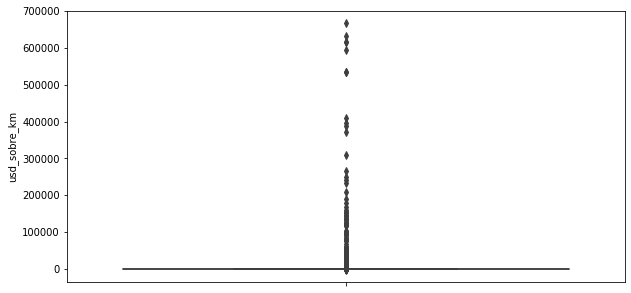

In [45]:
boxplot(df_columnas_interes.usd_sobre_km,orient="v")

Elimino las distancias nulas para que no haga ruido dividiendo

In [46]:
df_columnas_interes_sin_distancias_nulas=df_columnas_interes[df_columnas_interes["distancia_viaje_en_km"]>0]

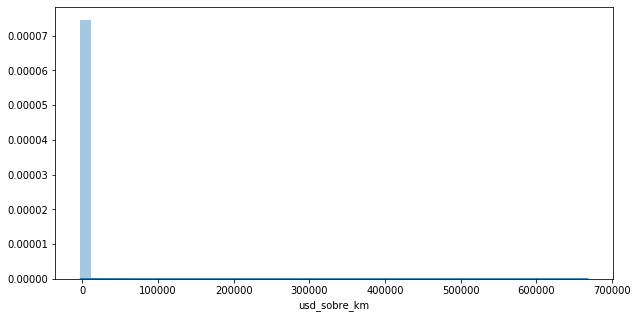

In [47]:
distplot(df_columnas_interes_sin_distancias_nulas.usd_sobre_km)

Le asigno un tope de 1000 usd/km

In [48]:
df_sindistanciasnulas_y_topedeusdsobrekm=df_columnas_interes_sin_distancias_nulas[df_columnas_interes_sin_distancias_nulas["usd_sobre_km"]<2000]

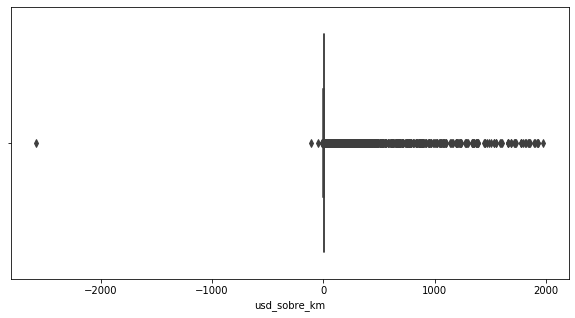

In [49]:
boxplot(df_sindistanciasnulas_y_topedeusdsobrekm.usd_sobre_km)

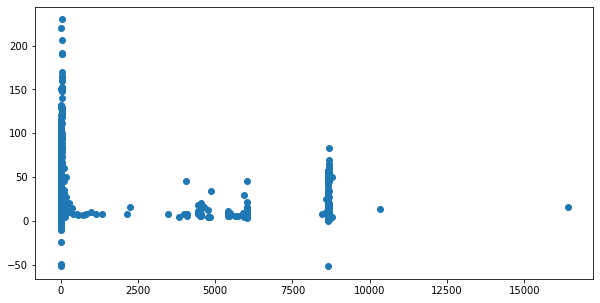

In [50]:
plt.scatter(x=df_sindistanciasnulas_y_topedeusdsobrekm.distancia_viaje_en_km,y=df_sindistanciasnulas_y_topedeusdsobrekm.fare_amount)

Tampoco pareciera haber algúna relación clara entre ambos conceptos.

## Análisis multivariado 

#### A modo de ejemplo para el desafío, voy a analizar las 3 variables:
    . Distancia en Km
    . Cantidad de pasajeros
    . Tarifa

In [51]:
##sns.pairplot(df_sindistanciasnulas_y_topedeusdsobrekm, height=3)
#plt.show()

Tarifa unitaria vs Distancia

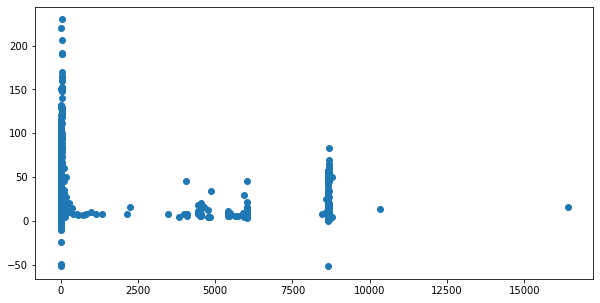

In [52]:
plt.scatter(x=df_sindistanciasnulas_y_topedeusdsobrekm.distancia_viaje_en_km,y=df_sindistanciasnulas_y_topedeusdsobrekm.fare_amount)

Cantidad de pasajeros vs Tarifa

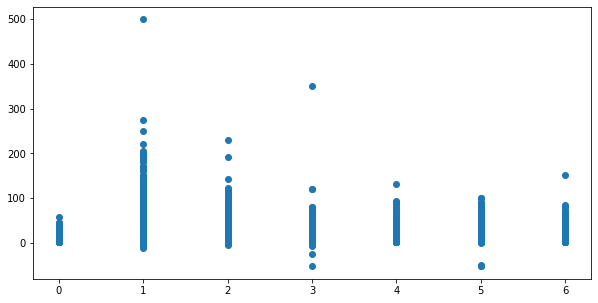

In [53]:
plt.scatter(df_sin_208_pasajeros.passenger_count,df_sin_208_pasajeros.fare_amount)

Haciendo el análisis multivariado, cómo ya se viene observando, hay que seguir trabajando el dataset para poder llegar a conclusiones valiosas para trabajarlo ya que no se puede ver ninguna relación entre variables tal como se tiene hasta ahora.

## Importo nuevamente el Dataset para que no apliquen los cambios hechos sobre el DF durante los diferentes análisis exploratorios

In [54]:
df=pd.read_csv("https://raw.githubusercontent.com/ezequielimeneses/TrabajoFinalDatascientistCoder/9ce01a9d9600daddcd290ab33e5988ebaaf9f6b0/uber.csv")
df=df.iloc[:,1:]
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [55]:
distancia=[]
for i in range(len(df.index)):
    punto_salida=df.pickup_latitude[i],df.pickup_longitude[i]
    punto_llegada=df.dropoff_latitude[i],df.dropoff_longitude[i]
    distancia_viaje=haversine(punto_salida,punto_llegada)
    distancia.append(distancia_viaje)
    distancia

In [56]:
df["distancia_viaje_en_km"]=distancia

### Geolocalizo los puntos con el paquete de geopy 

Genero una columna de coordenadas de llegada y coordenadas de salida con tipo string para poder trabajarla con "geolocator" y obtener las ciudades del dataset

In [57]:
df["latitud_salida_string"]=df["pickup_latitude"].astype(str)
df["longitud_salida_string"]=df["pickup_longitude"].astype(str)
df["latitud_llegada_string"]=df["dropoff_latitude"].astype(str)
df["longitud_llegada_string"]=df["dropoff_longitude"].astype(str)
df["coordenadas_salida"]=df.latitud_salida_string+","+df.longitud_salida_string
df["coordenadas_llegada"]=df.latitud_llegada_string+","+df.longitud_llegada_string

Hay puntos que tienen 0 en las coordenadas. Estos datos debo tratarlos como si fueran NAN y eliminarlos

In [58]:
df.pickup_latitude=df.pickup_latitude[df["pickup_latitude"]!=0]
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distancia_viaje_en_km,latitud_salida_string,longitud_salida_string,latitud_llegada_string,longitud_llegada_string,coordenadas_salida,coordenadas_llegada
0,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1,1.683325,40.73835372924805,-73.99981689453125,40.72321701049805,-73.99951171875,"40.73835372924805,-73.99981689453125","40.72321701049805,-73.99951171875"
1,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1,2.457593,40.728225,-73.994355,40.750325,-73.99471,"40.728225,-73.994355","40.750325,-73.99471"
2,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1,5.036384,40.74077,-74.005043,40.772647,-73.962565,"40.74077,-74.005043","40.772647,-73.962565"
3,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3,1.661686,40.790844,-73.976124,40.803349,-73.965316,"40.790844,-73.976124","40.803349,-73.965316"
4,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5,4.475456,40.744085,-73.925023,40.761247,-73.97308199999998,"40.744085,-73.925023","40.761247,-73.97308199999998"


In [59]:
df.dropna(subset=["pickup_latitude"],inplace=True)

In [60]:
df=df.reset_index(drop=True)

ciudades_salida=[]
for i in range(0,1000):
    location=geolocator.reverse(df.coordenadas_salida[i],timeout=None)
    if location is None:
        ciudades_salida.append("Sin datos")
    else:
        address=location.raw["address"]
        ciudad=address.get("city")
        ciudades_salida.append(ciudad)

Como es muy pesado de procesar geográficamente los 200.000 registros, tomé como solución de compromiso el marcar un cuadrado limitando los puntos que se encuentran dentro de allí cómo si fuera NY

In [61]:
latitud_ny_salida=(df["pickup_latitude"]>40.495898)&(df["pickup_latitude"]<40.911288)
latitud_ny_llegada=(df["dropoff_latitude"]>40.495898)&(df["dropoff_latitude"]<40.911288)
longitud_ny_salida=(df["pickup_longitude"]>-74.257124)&(df["pickup_longitude"]<-73.700942)
longitud_ny_llegada=(df["dropoff_longitude"]>-74.257124)&(df["dropoff_longitude"]<-73.700942)


In [62]:
df["latitud_ny_salida"]=latitud_ny_salida
df["latitud_ny_llegada"]=latitud_ny_llegada
df["longitud__ny_salida"]=longitud_ny_salida
df["longitud_ny_llegada"]=longitud_ny_llegada

In [63]:
df.shape

(196218, 19)

In [64]:
df=df[df["latitud_ny_salida"] == True]
df=df[df["latitud_ny_llegada"] == True]
df=df[df["longitud__ny_salida"] == True]
df=df[df["longitud_ny_llegada"] == True]

La distancia máxima en auto dentro de NYC es de 96,5606 km por lo que filtro los registros dentro de esa rango

In [65]:
distancia_entre0y96km=(df["distancia_viaje_en_km"]>0)&(df["distancia_viaje_en_km"]<96.5606)

In [66]:
df["distancia_entre0y96km"]=distancia_entre0y96km
df=df[df["distancia_entre0y96km"] == True]
df.shape

(193557, 20)

Me quedo solo con tarifas positivas (mayores a 0)

In [67]:
tarifa_mayora0=(df["fare_amount"]>0)
df["tarifa_mayora0"]=tarifa_mayora0
df=df[df["tarifa_mayora0"] == True]
df.shape

(193539, 21)

Convierto al formato correcto la columna de "pickup_datetime" para poder trabajar con la hora y fecha de dicha columna

In [68]:
df["pickup_datetime"]=pd.to_datetime(df["pickup_datetime"])

Obtengo 4 rangos horarios significativos para poder trabajar mejor con la hora

In [69]:
df=df.reset_index(drop=True)

In [70]:
rango_horario=[]
for i in range(len(df.index)):
    hora_viaje=df.pickup_datetime[i].hour
    if hora_viaje < 6:
        rango_horario.append("Madrugada")
    elif hora_viaje < 12:
        rango_horario.append("Mañana")
    elif hora_viaje < 19:
        rango_horario.append("Tarde")
    else:
        rango_horario.append("Noche")  
    
        

In [71]:
df["rango_horario"]=rango_horario

Agrego información al dataset viendo qué dia de la semana son los viajes y si estos son fin de semana o no

In [72]:
nro_dia_semana=[]
for i in range(len(df.index)):
    dia_semana=df.pickup_datetime[i].weekday()
    nro_dia_semana.append(dia_semana)


In [73]:
df["nro_dia_semana"]=nro_dia_semana

In [74]:
fin_de_semana=[]
for i in range(len(df.index)):
    dia_semana=df.pickup_datetime[i].weekday()
    if dia_semana < 5:
        fin_de_semana.append("Entre semana")
    else:
        fin_de_semana.append("Fin de semana")  

In [75]:
df["fin_de_semana"]=fin_de_semana

Finalmente, me quedo únicamente con las columnas de interés para el análisis, descartando las columnas creadas con el objetivo de hacer el data wrangling

In [76]:
columnas_interes=["fare_amount","pickup_datetime","pickup_longitude","pickup_latitude","dropoff_longitude","dropoff_latitude","passenger_count","distancia_viaje_en_km","coordenadas_salida","coordenadas_llegada","rango_horario","nro_dia_semana","fin_de_semana"]
df=df[columnas_interes]

In [77]:
df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distancia_viaje_en_km,coordenadas_salida,coordenadas_llegada,rango_horario,nro_dia_semana,fin_de_semana
0,7.5,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1,1.683325,"40.73835372924805,-73.99981689453125","40.72321701049805,-73.99951171875",Noche,3,Entre semana
1,7.7,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,1,2.457593,"40.728225,-73.994355","40.750325,-73.99471",Noche,4,Entre semana
2,12.9,2009-08-24 21:45:00+00:00,-74.005043,40.740770,-73.962565,40.772647,1,5.036384,"40.74077,-74.005043","40.772647,-73.962565",Noche,0,Entre semana
3,5.3,2009-06-26 08:22:21+00:00,-73.976124,40.790844,-73.965316,40.803349,3,1.661686,"40.790844,-73.976124","40.803349,-73.965316",Mañana,4,Entre semana
4,16.0,2014-08-28 17:47:00+00:00,-73.925023,40.744085,-73.973082,40.761247,5,4.475456,"40.744085,-73.925023","40.761247,-73.97308199999998",Tarde,3,Entre semana


### Analizo las nuevas variables creadas 

Text(0.5, 1, 'HeatMap con todas las columnas')

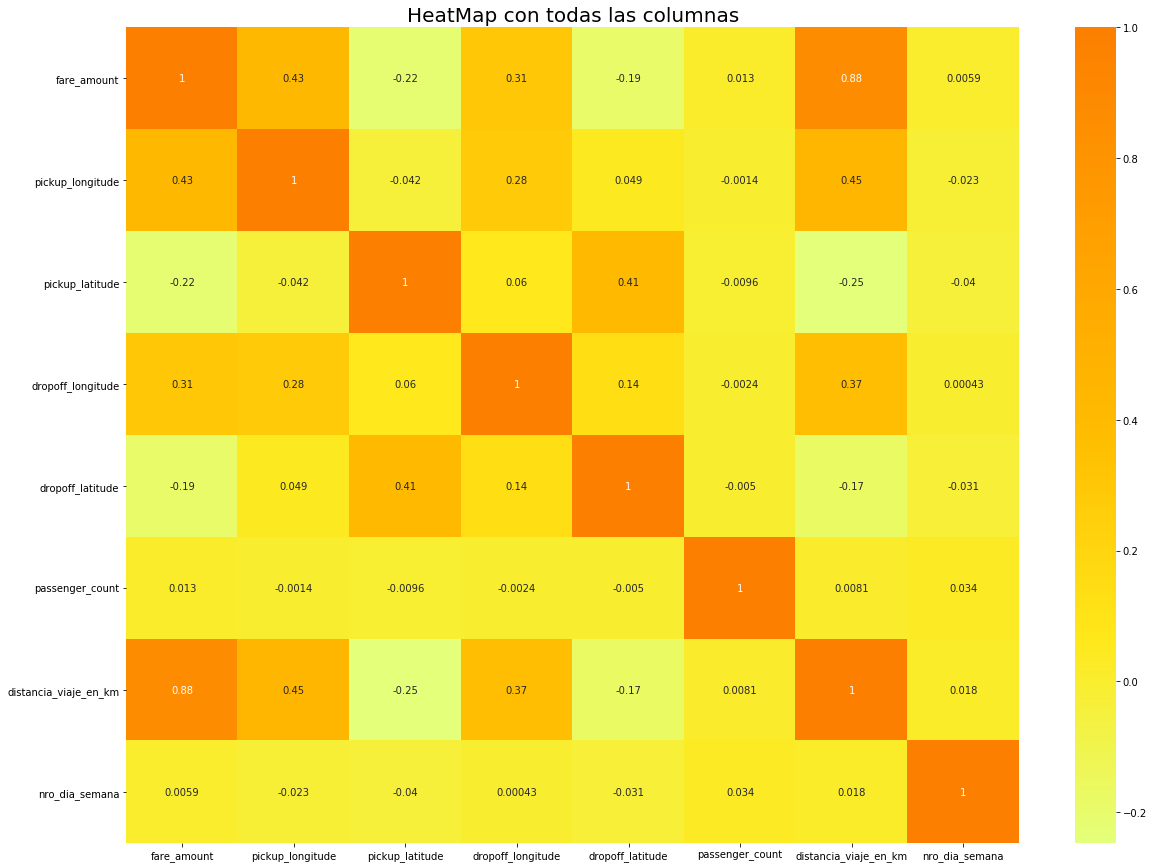

In [78]:
%matplotlib inline
plt.rcParams["figure.figsize"]=(20,15)
sns.heatmap(df.corr(),annot=True,cmap="Wistia")
plt.title("HeatMap con todas las columnas", fontsize=20)

Pareciera que la mayor incidencia en la tarifa la tiene la distancia del viaje y la longitud, tanto de comienzo como de fin del viaje. Esto puede ser porque exista multicolinealidad entre la longitud de la coordenada con la distancia en Km del viaje

Text(0, 0.5, 'Distancia en KM')

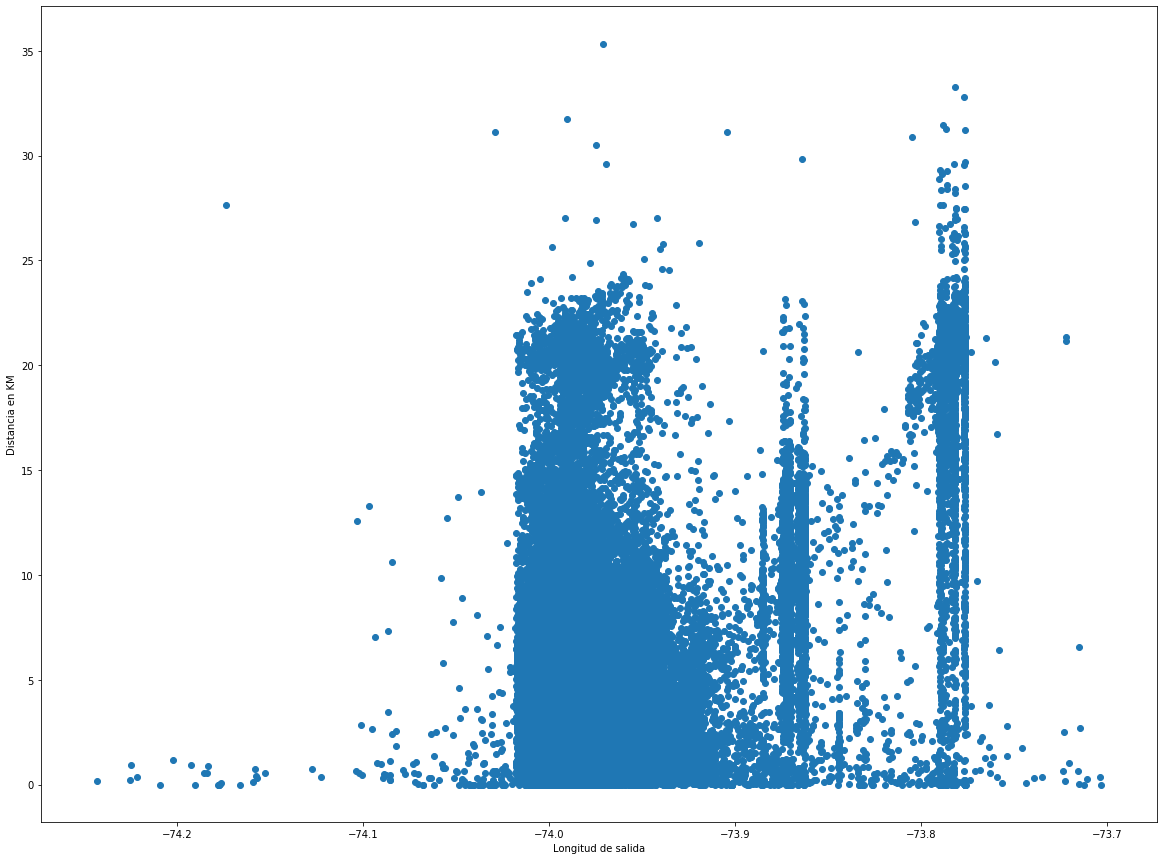

In [79]:
plt.scatter(x=df.pickup_longitude,y=df.distancia_viaje_en_km)
plt.xlabel("Longitud de salida")
plt.ylabel("Distancia en KM")

Text(0, 0.5, 'Distancia en KM')

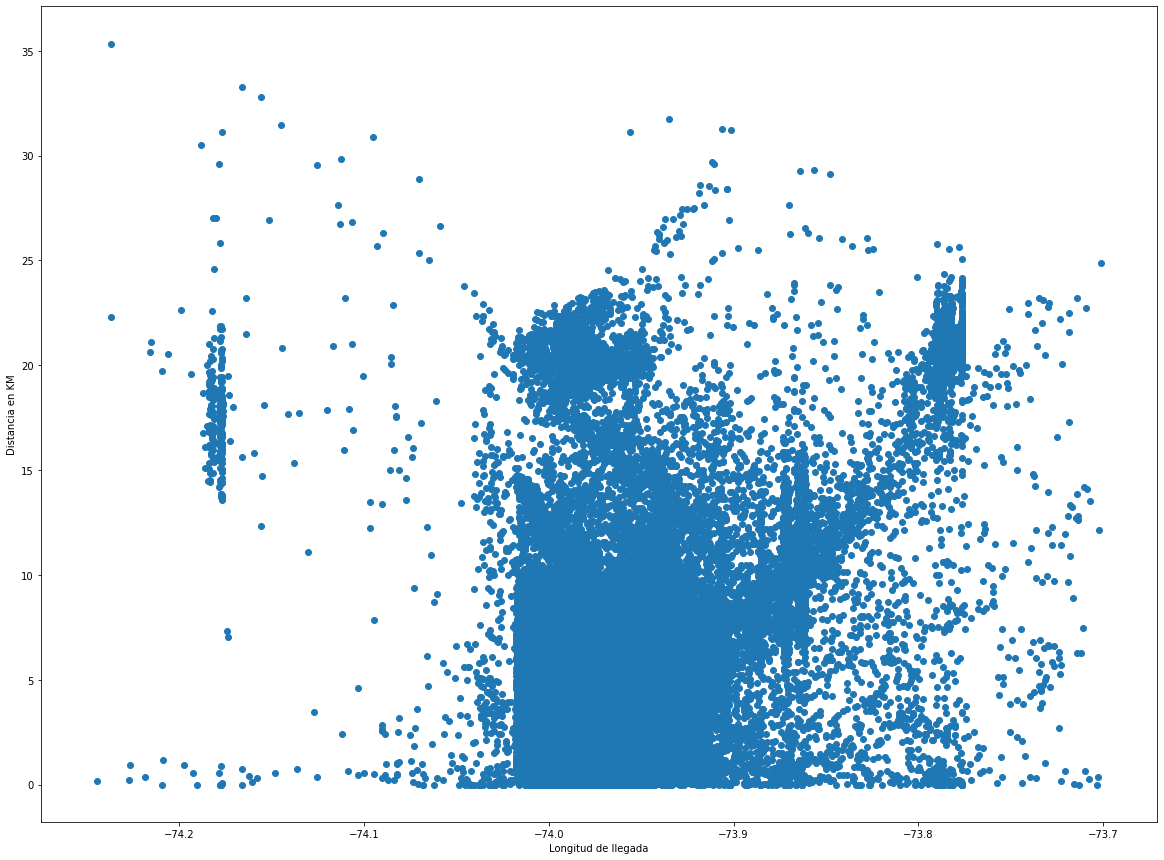

In [80]:
plt.scatter(x=df.dropoff_longitude,y=df.distancia_viaje_en_km)
plt.xlabel("Longitud de llegada")
plt.ylabel("Distancia en KM")

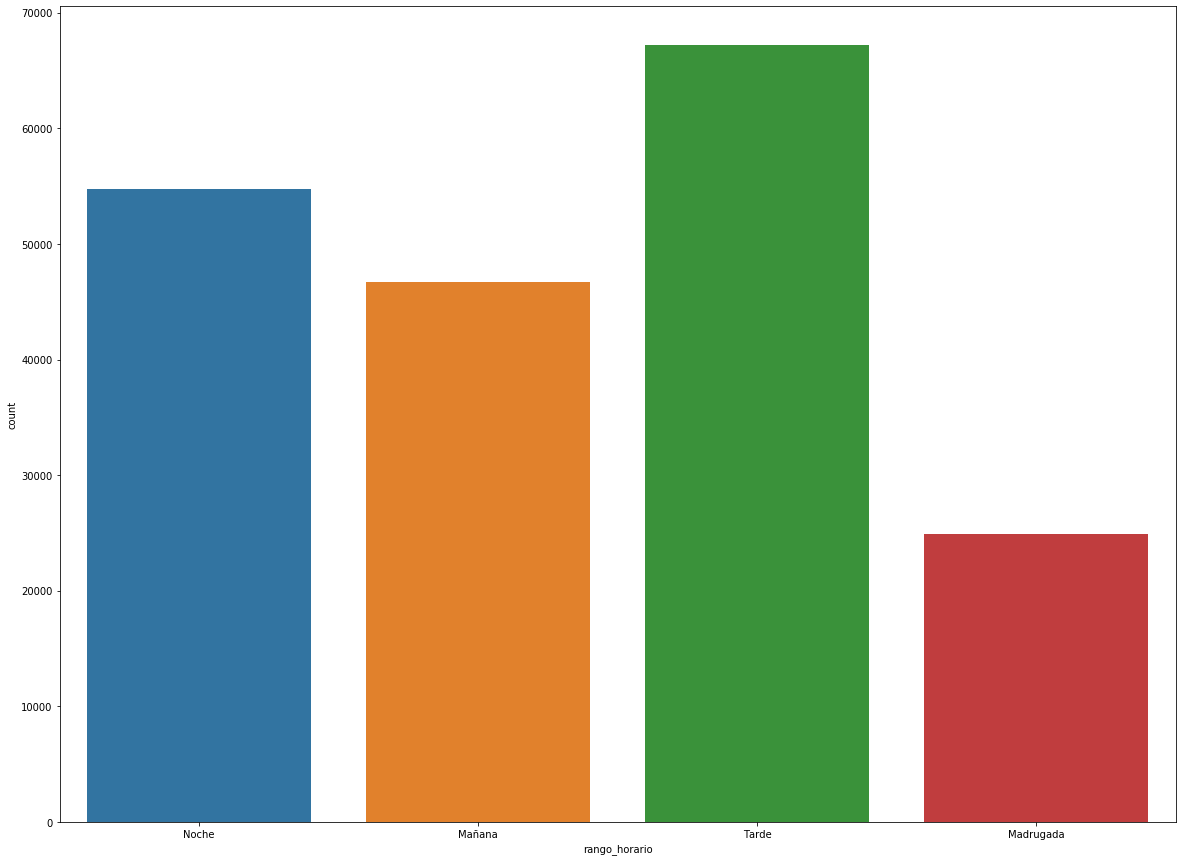

In [81]:
countplot(df.rango_horario)

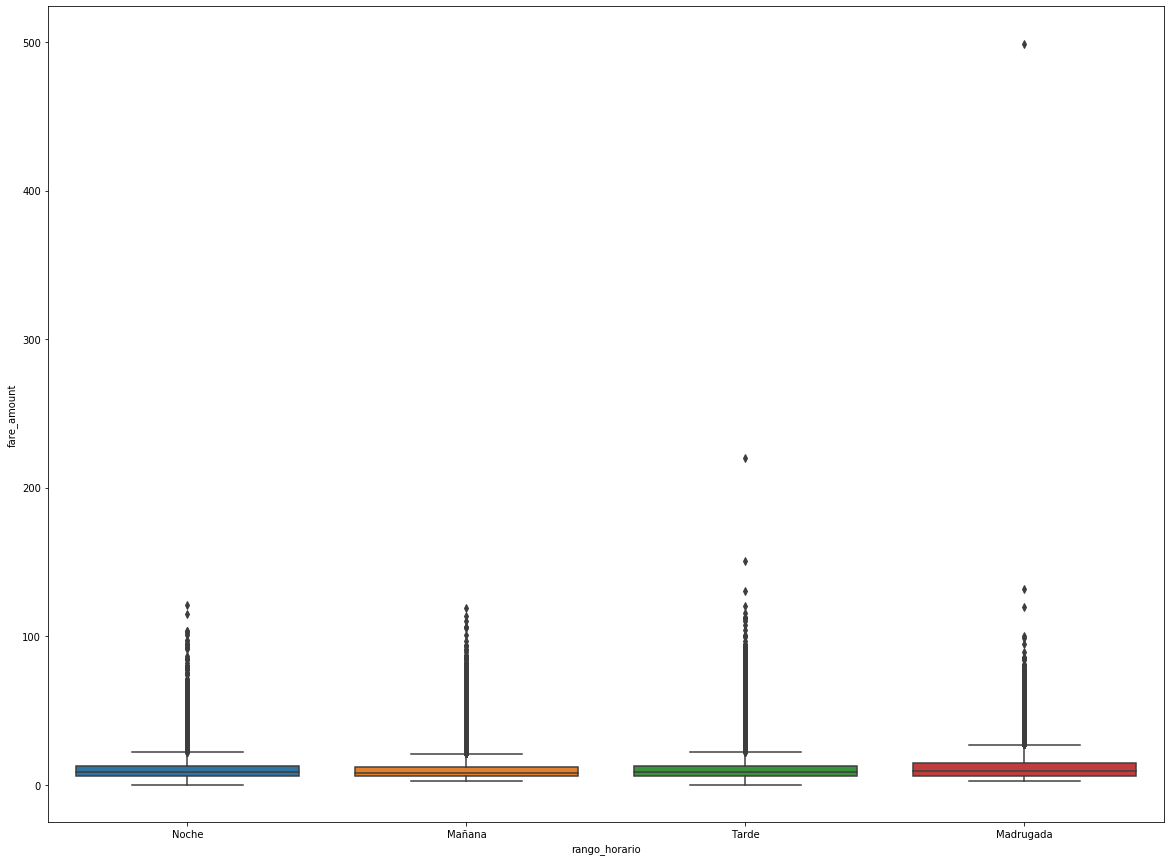

In [82]:
boxplot(x=df.rango_horario,y=df.fare_amount)

Se ve un incremento en el rango horario de madrugada

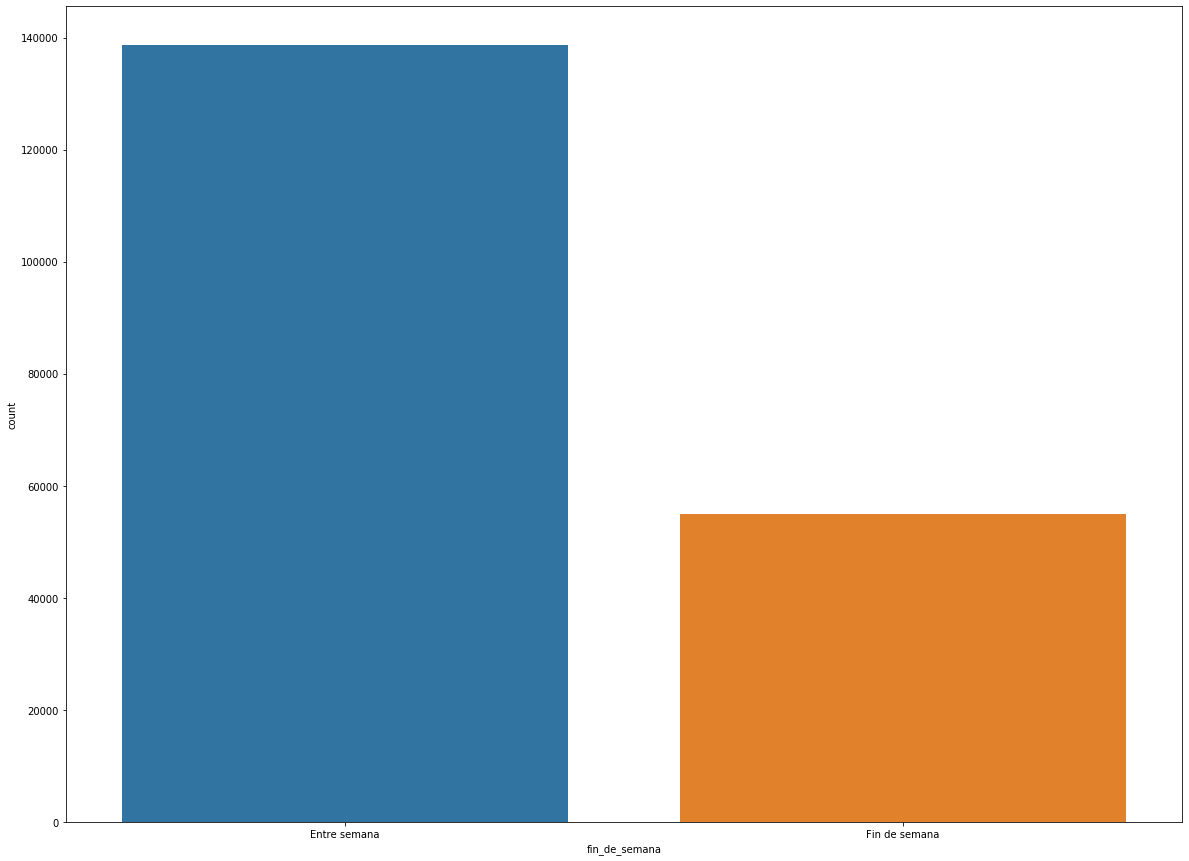

In [83]:
countplot(df.fin_de_semana)

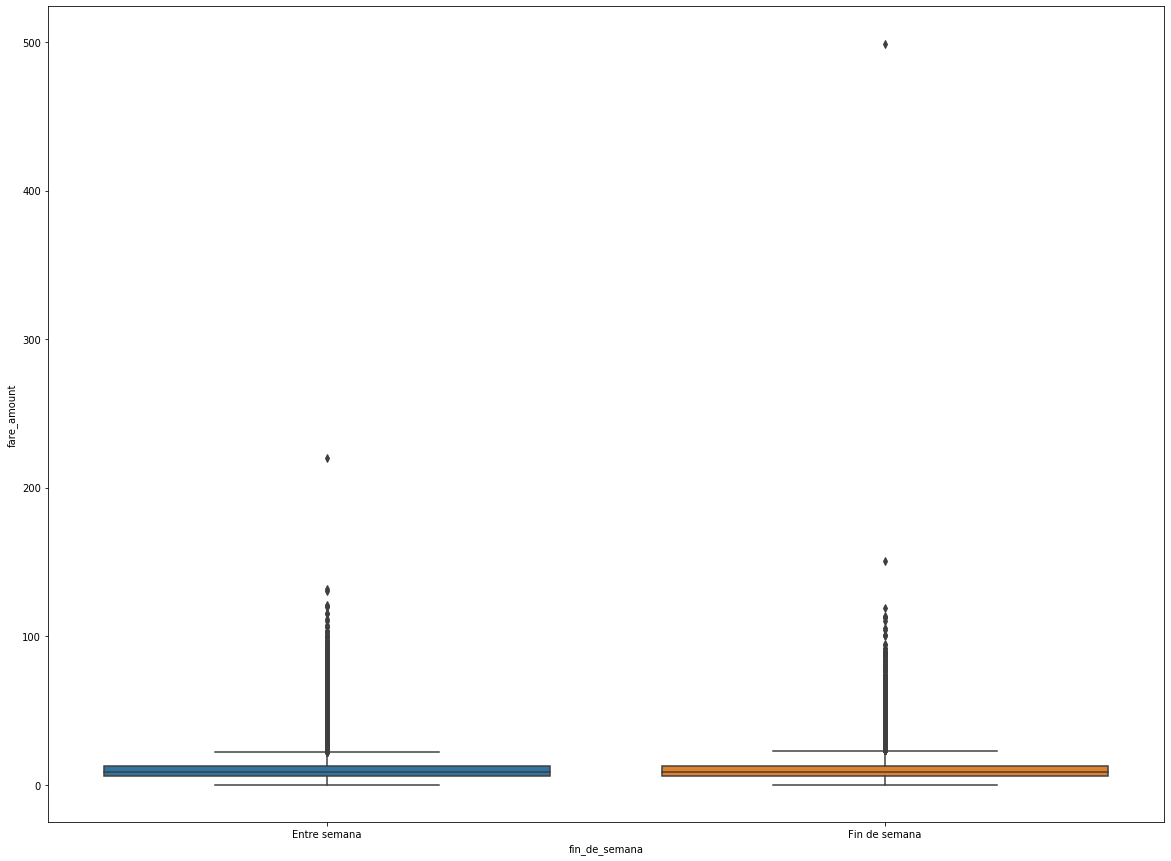

In [84]:
boxplot(x=df.fin_de_semana,y=df.fare_amount)

No pareciera haber una diferencia muy marcada entre la tarifa de fin de semana y entre semana

## Ejemplos de primeros ejemplos de algoritmos de regresión 

Se crearán modelos sin ningún tipo de optimización para verificar la mejora cuando se reafinan los modelos

## Algoritmo Regresión I 

Cómo la variable target es continua, utilizo el árbol de regresión

In [85]:
df.columns.values.tolist()

['fare_amount',
 'pickup_datetime',
 'pickup_longitude',
 'pickup_latitude',
 'dropoff_longitude',
 'dropoff_latitude',
 'passenger_count',
 'distancia_viaje_en_km',
 'coordenadas_salida',
 'coordenadas_llegada',
 'rango_horario',
 'nro_dia_semana',
 'fin_de_semana']

In [86]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distancia_viaje_en_km,nro_dia_semana
count,193539.000000,193539.000000,193539.000000,193539.000000,193539.000000,193539.000000,193539.000000,193539.000000
mean,11.297855,-73.975651,40.750838,-73.974721,40.751099,1.684668,3.340161,3.048765
std,9.459522,0.034184,0.026750,0.033769,0.030544,1.388337,3.556609,1.946915
min,0.010000,-74.243432,40.508697,-74.244837,40.511859,0.000000,0.000084,0.000000
25%,6.000000,-73.992287,40.736499,-73.991605,40.735372,1.000000,1.280447,1.000000
50%,8.500000,-73.982140,40.753314,-73.980591,40.753750,1.000000,2.179111,3.000000
75%,12.500000,-73.968529,40.767529,-73.965635,40.768316,2.000000,3.933487,5.000000
max,499.000000,-73.703262,40.908310,-73.700963,40.909967,208.000000,35.341909,6.000000


In [87]:
df = pd.get_dummies(data=df,columns=["rango_horario","fin_de_semana"], drop_first=True)

In [88]:
X=df.drop(["fare_amount","pickup_datetime","coordenadas_llegada","coordenadas_salida"],axis=1)
y=df["fare_amount"]

In [89]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3)

In [90]:
tree=DecisionTreeRegressor(max_depth=2)

In [91]:
tree.fit(X_train,y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [92]:
y_train_predict=tree.predict(X_train)
y_test_predict=tree.predict(X_test)

In [93]:
train_mean_squared_error=mean_squared_error(y_train,y_train_predict)
test_mean_squared_error=mean_squared_error(y_test,y_test_predict)
print(train_mean_squared_error)
print(test_mean_squared_error)

23.49557205030153
27.67861117140443


In [94]:
tree.score(X_test,y_test)

0.7004092199058034

Si bien llegamos a un modelo válido, se trata de un error muy grande ya que la media de la tarifa en el dataset es cercana la 11 y el valor de RMSE lo duplica.

### Intento dandole mayor profundidad al árbol 

In [95]:
X2=df.drop(["fare_amount","pickup_datetime","coordenadas_llegada","coordenadas_salida"],axis=1)
y2=df["fare_amount"]

In [96]:
X2_train,X2_test,y2_train,y2_test=train_test_split(X2,y2,test_size=0.3)

In [97]:
tree2=DecisionTreeRegressor(max_depth=10)

In [98]:
tree2.fit(X2_train,y2_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=10,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [99]:
y2_train_predict=tree2.predict(X2_train)
y2_test_predict=tree2.predict(X2_test)

In [100]:
train2_mean_squared_error=mean_squared_error(y2_train,y2_train_predict)
test2_mean_squared_error=mean_squared_error(y2_test,y2_test_predict)
print(train2_mean_squared_error)
print(test2_mean_squared_error)

11.649272809289291
21.568050469286483


In [101]:
tree2.score(X2_test,y2_test)

0.7658061418471364

Si bien mejora el RMSE con mayor profundidad, vemos como se produce el efecto de overfitting en el modelo por la gran diferencia de esta métrica cuando se trata del conjunto de test respecto al de entrenamiento.

## Algortimo de regresión II 

### KNN

In [102]:
knn=KNeighborsRegressor()

In [103]:
knn.fit(X_train,y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

In [104]:
knn_predict_train=knn.predict(X_train)
knn_predict_test=knn.predict(X_test)

In [105]:
print(knn.score(X_train,y_train))
print(knn.score(X_test,y_test))

0.8527946182424093
0.7444432814146369


In [106]:
knn_mean_squared_error_train=mean_squared_error(y_train,knn_predict_train)
knn_mean_squared_error_test=mean_squared_error(y_test,knn_predict_test)

In [107]:
print(mean_squared_error(y_train,knn_predict_train))
print(mean_squared_error(y_test,knn_predict_test))

12.988723920222618
23.610389624608178


Obtuvimos un buen R2 pero un RMSE grande aún.

## Algoritmo Regresión III

### Random Forest 

Aplico la misma lógica: un random forest con árboles de profundidad máxima 2 y otro modelo con árboles de profundidad máxima 10

In [108]:
model=RandomForestRegressor(max_depth=2)

In [109]:
model.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=2, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [110]:
model_predict_train=model.predict(X_train)
model_predict_test=model.predict(X_test)

In [111]:
print(model.score(X_train,y_train))
print(model.score(X_test,y_test))

0.7406381696748416
0.7073661817080037


In [112]:
print(mean_squared_error(y_train,model_predict_train))
print(mean_squared_error(y_test,model_predict_test))


22.884891634496206
27.03587096225356


In [113]:
model2=RandomForestRegressor(max_depth=10)

In [114]:
model2.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [115]:
model2_predict_train=model2.predict(X_train)
model2_predict_test=model2.predict(X_test)

In [116]:
print(model2.score(X_train,y_train))
print(model2.score(X_test,y_test))

0.873413830315994
0.8003576735471291


In [117]:
print(mean_squared_error(y_train,model2_predict_train))
print(mean_squared_error(y_test,model2_predict_test))

11.169379750338011
18.44456737121947


Con este nivel de profundidad obtenemos un buen R2 y sin tener mucha diferencia entre test y train como nos pasaba en el árbol de decisión. Hay más diferencia tomando como medida el RMSE.

### Comparación de métricas de modelos 

In [118]:
data=[["Árbol profundidad 2",tree.score(X_train,y_train),tree.score(X_test,y_test),train_mean_squared_error,test_mean_squared_error],["Árbol profundidad 10",tree2.score(X_train,y_train),tree2.score(X_test,y_test),train2_mean_squared_error,test2_mean_squared_error],["KNeighborsRegressor",knn.score(X_train,y_train),knn.score(X_test,y_test),knn_mean_squared_error_train,knn_mean_squared_error_test],["Random Forest Profundidad 2",model.score(X_train,y_train),model.score(X_test,y_test),mean_squared_error(y_train,model_predict_train),mean_squared_error(y_test,model_predict_test)],["Random Forest Profundidad 10",model2.score(X_train,y_train),model2.score(X_test,y_test),mean_squared_error(y_train,model2_predict_train),mean_squared_error(y_test,model2_predict_test)]]

In [119]:
tabla=pd.DataFrame(data,columns=["Modelo","R2 Train","R2 Test","RMSE Train","RMSE Test"])

In [120]:
tabla

,Modelo,R2 Train,R2 Test,RMSE Train,RMSE Test
0,Árbol profundidad 2,0.733717,0.700409,23.495572,27.678611
1,Árbol profundidad 10,0.848015,0.811029,11.649273,21.568050
2,KNeighborsRegressor,0.852795,0.744443,12.988724,23.610390
3,Random Forest Profundidad 2,0.740638,0.707366,22.884892,27.035871
4,Random Forest Profundidad 10,0.873414,0.800358,11.169380,18.444567


#### A simple vista y comparando únicamente estas métricas, el modelo que mejor funciona pareciera ser el Random Forest, configurando una profundidad máxima en los árboles de 10

## Limpieza OUTLIERS 

Se trata de limpiar los OUTLIERS de las columnas de tarifa y distancia que son las más dispersas para seguir afinando el modelo. Se utlizará el concepto de +/- 1,5 el recorrido estadístico (distancia entre 1er y 3er cuartil)

In [121]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distancia_viaje_en_km,nro_dia_semana,rango_horario_Mañana,rango_horario_Noche,rango_horario_Tarde,fin_de_semana_Fin de semana
count,193539.000000,193539.000000,193539.000000,193539.000000,193539.000000,193539.000000,193539.000000,193539.000000,193539.000000,193539.000000,193539.000000,193539.000000
mean,11.297855,-73.975651,40.750838,-73.974721,40.751099,1.684668,3.340161,3.048765,0.241114,0.283059,0.347108,0.283679
std,9.459522,0.034184,0.026750,0.033769,0.030544,1.388337,3.556609,1.946915,0.427761,0.450486,0.476052,0.450784
min,0.010000,-74.243432,40.508697,-74.244837,40.511859,0.000000,0.000084,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,-73.992287,40.736499,-73.991605,40.735372,1.000000,1.280447,1.000000,0.000000,0.000000,0.000000,0.000000
50%,8.500000,-73.982140,40.753314,-73.980591,40.753750,1.000000,2.179111,3.000000,0.000000,0.000000,0.000000,0.000000
75%,12.500000,-73.968529,40.767529,-73.965635,40.768316,2.000000,3.933487,5.000000,0.000000,1.000000,1.000000,1.000000
max,499.000000,-73.703262,40.908310,-73.700963,40.909967,208.000000,35.341909,6.000000,1.000000,1.000000,1.000000,1.000000


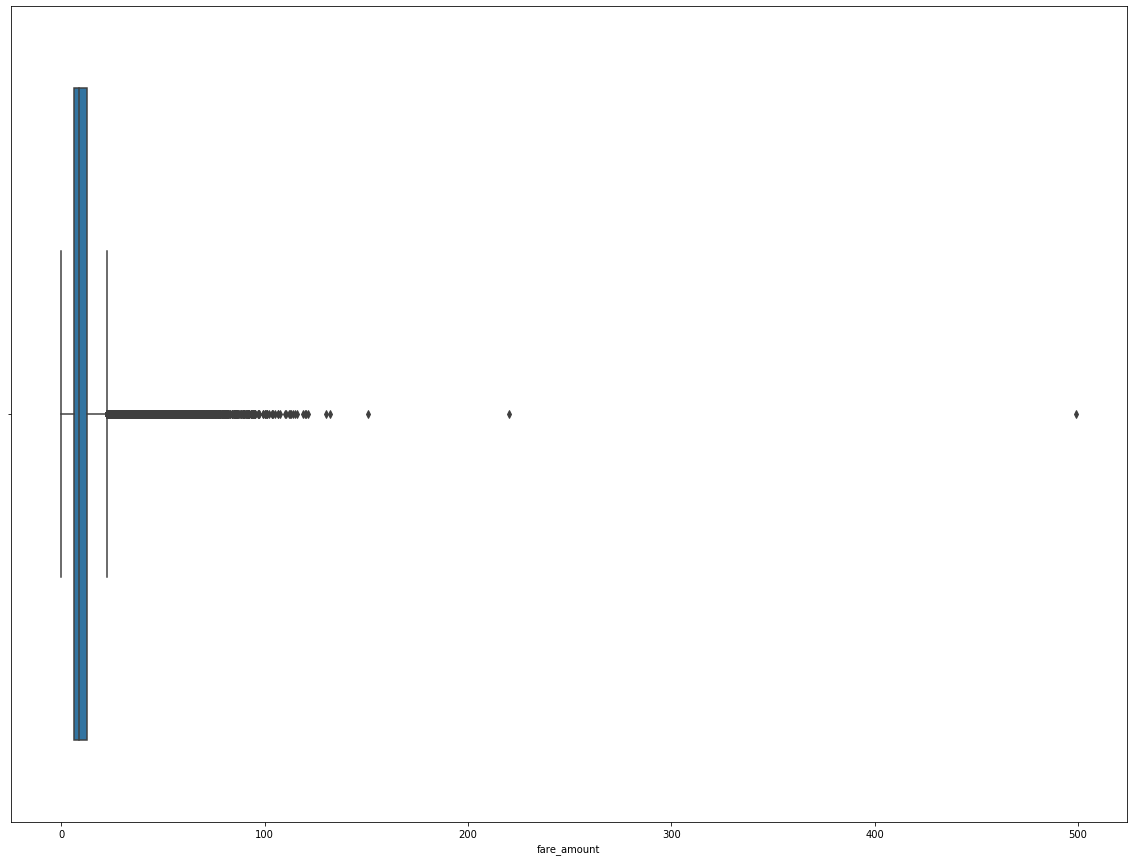

In [122]:
#verificó la dispersión ya vista para evaluar, antes y después, de aplicar la limpieza
boxplot(df.fare_amount)

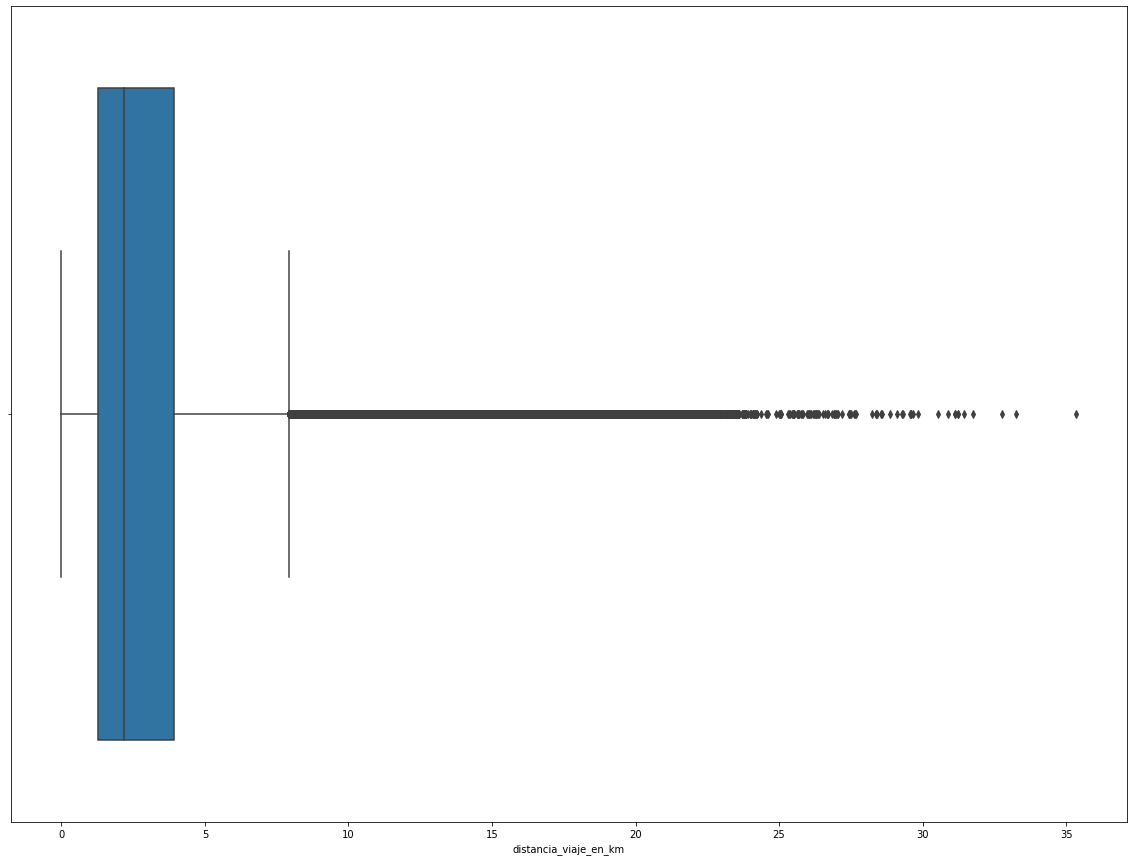

In [123]:
boxplot(df.distancia_viaje_en_km)

Cálculo medidas de boxplot para detectar outliers

In [124]:
median_tarifa = np.median(df.fare_amount)
upper_quartile_tarifa = np.percentile(df.fare_amount, 75)
lower_quartile_tarifa = np.percentile(df.fare_amount, 25)
iqr_tarifa = upper_quartile_tarifa - lower_quartile_tarifa
upper_whisker_tarifa = df.fare_amount[df.fare_amount<=upper_quartile_tarifa+1.5*iqr_tarifa].max()
lower_whisker_tarifa = df.fare_amount[df.fare_amount>=lower_quartile_tarifa-1.5*iqr_tarifa].min()

median_distanciakm = np.median(df.distancia_viaje_en_km)
upper_quartile_distanciakm = np.percentile(df.distancia_viaje_en_km, 75)
lower_quartile_distanciakm = np.percentile(df.distancia_viaje_en_km, 25)
iqr_distanciakm = upper_quartile_distanciakm - lower_quartile_distanciakm
upper_whisker_distanciakm = df.distancia_viaje_en_km[df.distancia_viaje_en_km<=upper_quartile_distanciakm+1.5*iqr_distanciakm].max()
lower_whisker_distanciakm = df.distancia_viaje_en_km[df.distancia_viaje_en_km>=lower_quartile_distanciakm-1.5*iqr_distanciakm].min()

In [125]:
condicion_tarifa = df["fare_amount"] <= upper_whisker_tarifa
condicion_distanciakm = df["distancia_viaje_en_km"] <= upper_whisker_distanciakm
df = df[condicion_tarifa]
df = df[condicion_distanciakm]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


Compruebo que haya mejorado la variabilidad

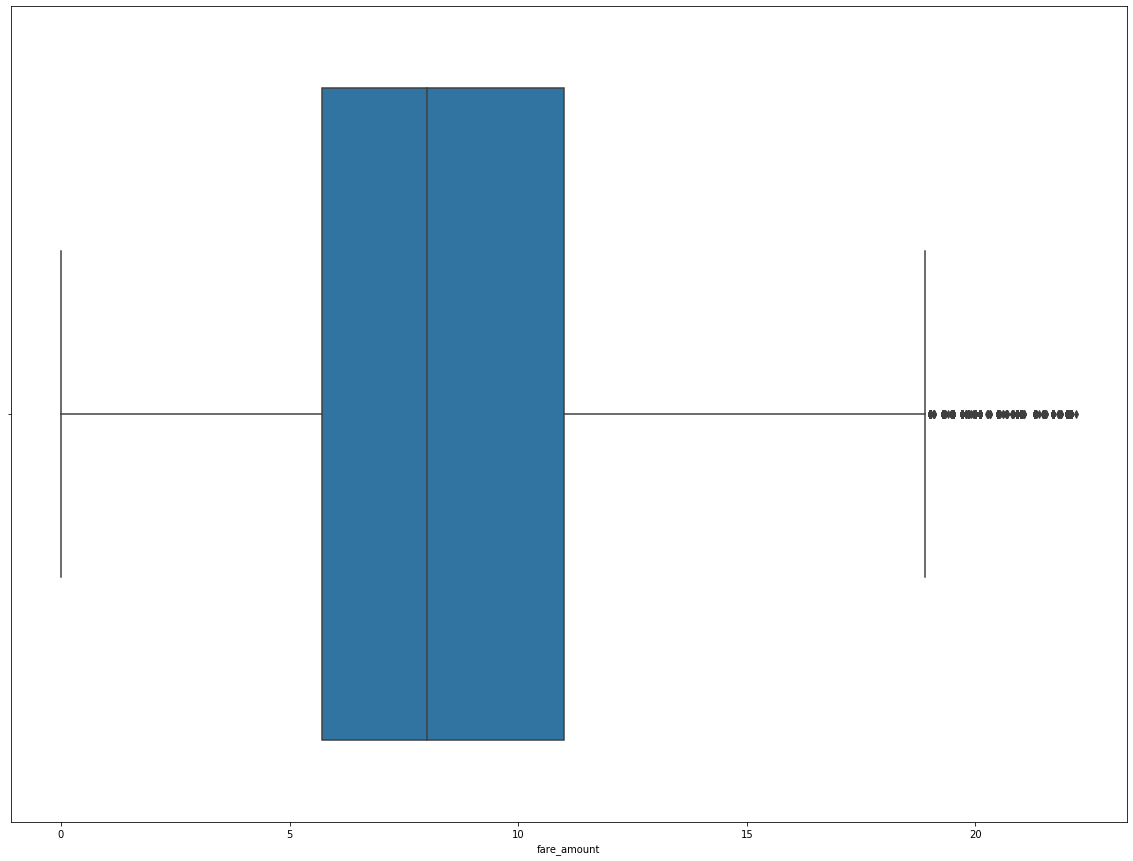

In [126]:
boxplot(df.fare_amount)

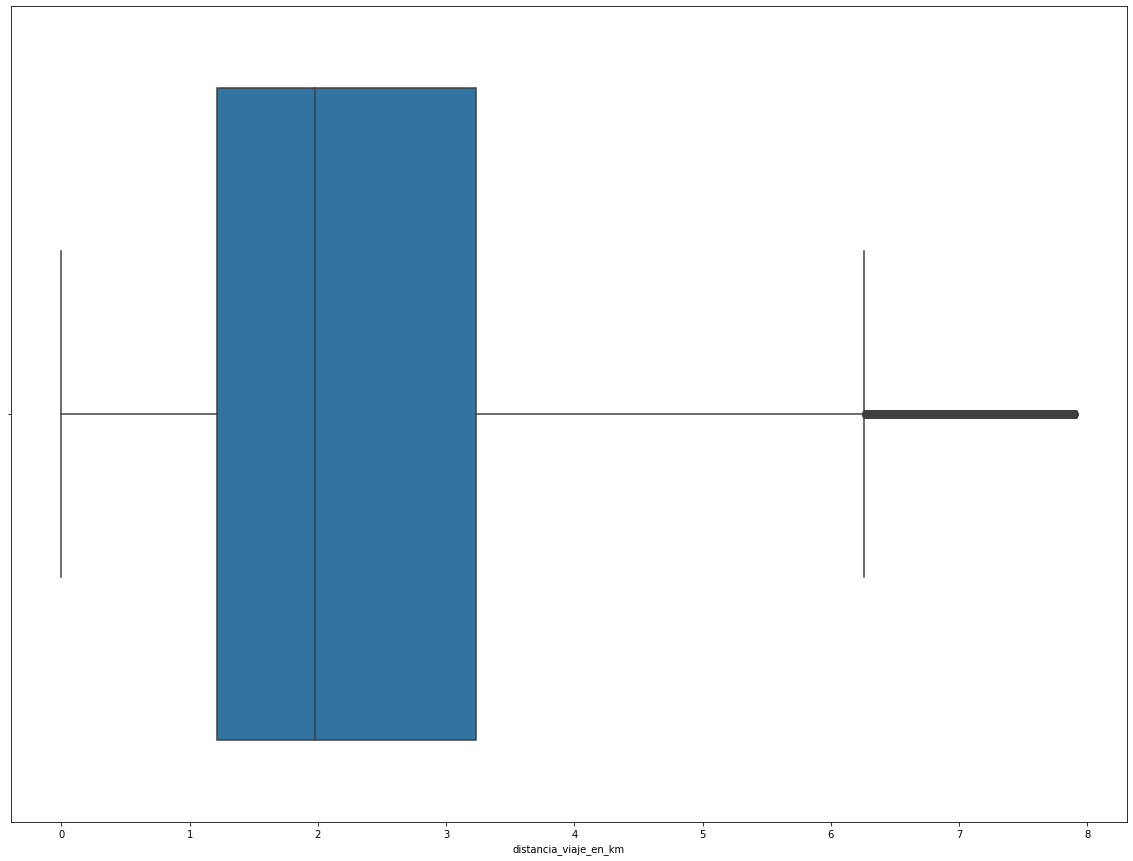

In [127]:
boxplot(df.distancia_viaje_en_km)

In [128]:
df=df.drop(["coordenadas_salida","coordenadas_llegada"], axis=1)

In [129]:
df_procesado= df.copy()

In [130]:
df_procesado_X = df_procesado.drop(["fare_amount","pickup_datetime"], axis=1)
df_procesado_y=df["fare_amount"]
df_procesado_X

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distancia_viaje_en_km,nro_dia_semana,rango_horario_Mañana,rango_horario_Noche,rango_horario_Tarde,fin_de_semana_Fin de semana
0,-73.999817,40.738354,-73.999512,40.723217,1,1.683325,3,0,1,0,0
1,-73.994355,40.728225,-73.994710,40.750325,1,2.457593,4,0,1,0,0
2,-74.005043,40.740770,-73.962565,40.772647,1,5.036384,0,0,1,0,0
3,-73.976124,40.790844,-73.965316,40.803349,3,1.661686,4,1,0,0,0
4,-73.925023,40.744085,-73.973082,40.761247,5,4.475456,3,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
193533,-73.983070,40.760770,-73.972972,40.754177,1,1.122879,4,0,0,1,0
193534,-73.987042,40.739367,-73.986525,40.740297,1,0.112210,6,1,0,0,1
193535,-73.984722,40.736837,-74.006672,40.739620,1,1.875053,4,0,0,0,0
193537,-73.997124,40.725452,-73.983215,40.695415,1,3.539720,2,0,0,1,0


## Estandarizo columnas predictoras

In [133]:
std=StandardScaler()
df_procesado_X_std=std.fit_transform(df_procesado_X)
df_procesado_X_std=pd.DataFrame(df_procesado_X_std,columns=df_procesado_X.columns)

In [134]:
df_procesado_X_std

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distancia_viaje_en_km,nro_dia_semana,rango_horario_Mañana,rango_horario_Noche,rango_horario_Tarde,fin_de_semana_Fin de semana
0,-0.931867,-0.588105,-0.935601,-1.141166,-0.488691,-0.457920,-0.024098,-0.566499,1.579523,-0.730112,-0.628354
1,-0.670161,-1.020724,-0.718193,-0.073995,-0.488691,0.021818,0.490808,-0.566499,1.579523,-0.730112,-0.628354
2,-1.182275,-0.484901,0.737241,0.804764,-0.488691,1.619642,-1.568817,-0.566499,1.579523,-0.730112,-0.628354
3,0.203375,1.653866,0.612683,2.013422,0.943661,-0.471328,0.490808,1.765227,-0.633102,-0.730112,-0.628354
4,2.651872,-0.343310,0.261061,0.355975,2.376013,1.272090,-0.024098,-0.566499,-0.633102,1.369654,-0.628354
...,...,...,...,...,...,...,...,...,...,...,...
174177,-0.129442,0.369342,0.266041,0.077648,-0.488691,-0.805173,0.490808,-0.566499,-0.633102,1.369654,-0.628354
174178,-0.319760,-0.544826,-0.347600,-0.468772,-0.488691,-1.431386,1.520620,1.765227,-0.633102,-0.730112,1.591460
174179,-0.208597,-0.652888,-1.259798,-0.495423,-0.488691,-0.339125,0.490808,-0.566499,-0.633102,-0.730112,-0.628354
174180,-0.802824,-1.139147,-0.197747,-2.235640,-0.488691,0.692306,-0.539005,-0.566499,-0.633102,1.369654,-0.628354


## PCA 

In [135]:
pca = PCA()
pca.fit(df_procesado_X_std)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [136]:
print(pca.explained_variance_ratio_)
print(np.cumsum(pca.explained_variance_ratio_))

[0.20598859 0.16486437 0.13492556 0.12134193 0.09751235 0.09015986
 0.08002075 0.05303564 0.01994455 0.01791088 0.0142955 ]
[0.20598859 0.37085296 0.50577852 0.62712045 0.72463281 0.81479267
 0.89481342 0.94784906 0.96779361 0.9857045  1.        ]


Me quedo con los primeros 7 componentes, ya que con estos explico casi el 90% de la varianza de los datos

In [137]:
pca = PCA(n_components=7)
X=pca.fit_transform(df_procesado_X_std)
y=df_procesado_y

### Hypertuning

##### Consideraciones:
    . Voy a analizar 3 algoritmos de regresión: árbol de decisión, random forest y k vecinos.
    . Para cada uno de estos voy a hacer una búsqueda de hyperparametros "óptimos".
    . Cómo luego los voy a evaluar al mejor modelo con RMSE, voy a comprobar con RANDOMIZEDGRIDSEARCH CV con esa    métrica.

Random Forest

In [ ]:
random_forest=RandomForestRegressor()
grid_rf={"n_estimators": [200,400,600,800,1000,1200,1400,1600,1800,2000],
        "max_depth": [10,20,30,40,50,60,70,80,90,100,None]}
cv=KFold(n_splits=5,shuffle=True)
tunner_rf=RandomizedSearchCV(estimator=random_forest,n_iter=5,param_distributions=grid_rf, cv=cv,scoring="neg_root_mean_squared_error",n_jobs=-1)
_=tunner_rf.fit(X,y)

Debido a falta de recursos en mi computadora no corro la grilla de Random Forest porque no tengo los recursos suficientes.

In [ ]:
tunner_rf.best_params_

Árbol de decisión

In [138]:
tree_regressor=DecisionTreeRegressor()
grid_tr={"ccp_alpha":[0,0.05,0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45,0.50],
        "max_features": ["auto","sqrt"],
        "max_depth": [10,20,30,40,50,60,70,80,90,100,None],
        "min_samples_split": [2,5,10],
        "min_samples_leaf": [1,2,4]}
cv=KFold(n_splits=5,shuffle=True)
tunner_tr=RandomizedSearchCV(estimator=tree_regressor,n_iter=100,param_distributions=grid_tr, cv=cv,scoring="neg_root_mean_squared_error")
_=tunner_tr.fit(X,y)

In [139]:
tunner_tr.best_params_

{'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 100,
 'ccp_alpha': 0.05}

K Neighbors regressor


In [140]:
knr=KNeighborsRegressor()
grid_knr={"n_neighbors":[2,3,4,5,6,7,8,9,10],
        "weights": ["uniform","distance"],
        "p": [1,2]}
cv=KFold(n_splits=5,shuffle=True)
tunner_knr=RandomizedSearchCV(estimator=knr,n_iter=100,param_distributions=grid_knr, cv=cv,scoring="neg_root_mean_squared_error")
_=tunner_knr.fit(X,y)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:281: UserWarning: The total space of parameters 36 is smaller than n_iter=100. Running 36 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


In [141]:
tunner_knr.best_params_

{'weights': 'uniform', 'p': 2, 'n_neighbors': 10}

LIGHT GBM

In [142]:
light_gbm=LGBMRegressor()
grid_lgbm={"n_estimators": [100,500,1000,5000],
          "max_depth": [-1,1,3,5,10,20],
          "subsample":[0.5,1],
          "learning_rate":[0.001,0.01,0.1],
          "boosting_type": ["gbdt"]}
cv=KFold(n_splits=5,shuffle=True)
tunner_lgbm=RandomizedSearchCV(estimator=light_gbm,n_iter=100,param_distributions=grid_lgbm, cv=cv,scoring="neg_root_mean_squared_error")
_=tunner_lgbm.fit(X,y)

          

In [143]:
tunner_lgbm.best_params_

{'subsample': 0.5,
 'n_estimators': 5000,
 'max_depth': 20,
 'learning_rate': 0.01,
 'boosting_type': 'gbdt'}

## Validación con CV 

Random Forest

In [148]:
r_forest=RandomForestRegressor(n_estimators=100, max_depth=15,max_features="auto")
RMSE_r_forest=cross_val_score(r_forest,X,y,cv=5,scoring="neg_root_mean_squared_error")
MAE_r_forest=cross_val_score(r_forest,X,y,cv=5,scoring="neg_mean_absolute_error")
R2_r_forest=cross_val_score(r_forest,X,y,cv=5,scoring="r2")

Tree Regresor

In [144]:
tree_regressor=DecisionTreeRegressor(min_samples_split=2,min_samples_leaf=1,max_features="auto",max_depth=100,ccp_alpha=0.05)
RMSE_tr=cross_val_score(tree_regressor,X,y,cv=5,scoring="neg_root_mean_squared_error")
MAE_tr=cross_val_score(tree_regressor,X,y,cv=5,scoring="neg_mean_absolute_error")
R2_tr=cross_val_score(tree_regressor,X,y,cv=5,scoring="r2")

K Neighbors

In [145]:
knr=KNeighborsRegressor(weights="uniform",p=2,n_neighbors=10)
RMSE_knr=cross_val_score(knr,X,y,cv=5,scoring="neg_root_mean_squared_error")
MAE_knr=cross_val_score(knr,X,y,cv=5,scoring="neg_mean_absolute_error")
R2_knr=cross_val_score(knr,X,y,cv=5,scoring="r2")

LIGHT GBM

In [146]:
light_gbm=LGBMRegressor(subsample=0.5,n_estimators=5000,max_depth=20,learning_rate=0.01,boosting_type="gbdt")
RMSE_lgbm=cross_val_score(light_gbm,X,y,cv=5,scoring="neg_root_mean_squared_error")
MAE_lgbm=cross_val_score(light_gbm,X,y,cv=5,scoring="neg_mean_absolute_error")
R2_lgbm=cross_val_score(light_gbm,X,y,cv=5,scoring="r2")

## Comparación de métricas de modelos 

Voy a analizar gráficamente cuál es el mejor modelo, según las diferentes métricas.

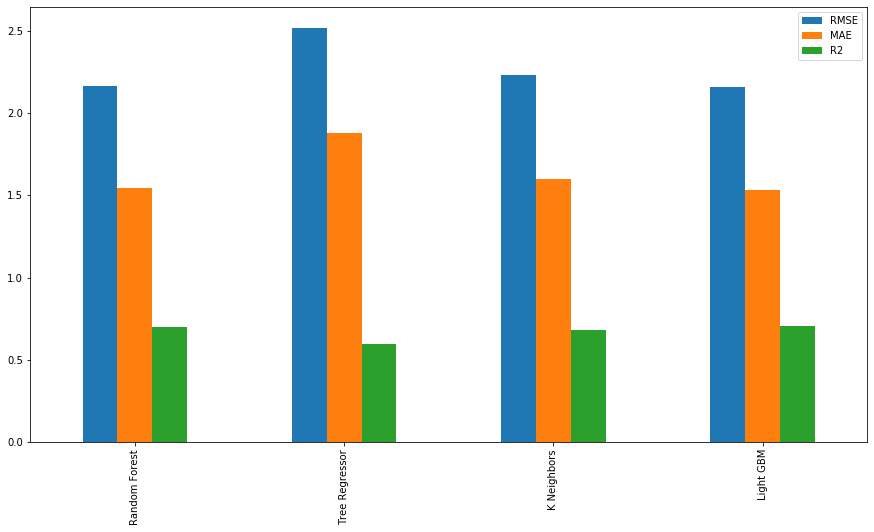

In [149]:
plot_data=pd.DataFrame({
    "RMSE": [np.absolute(np.mean(RMSE_r_forest)),np.absolute(np.mean(RMSE_tr)),np.absolute(np.mean(RMSE_knr)),np.absolute(np.mean(RMSE_lgbm))],
    "MAE": [np.absolute(np.mean(MAE_r_forest)),np.absolute(np.mean(MAE_tr)),np.absolute(np.mean(MAE_knr)),np.absolute(np.mean(MAE_lgbm))],
    "R2": [np.absolute(np.mean(R2_r_forest)),np.absolute(np.mean(R2_tr)),np.absolute(np.mean(R2_knr)),np.absolute(np.mean(R2_lgbm))]},
    index=["Random Forest","Tree Regressor","K Neighbors", "Light GBM"])
plot_data.plot(kind="bar", figsize=(15,8))


In [150]:
plot_data

,RMSE,MAE,R2
Random Forest,2.166699,1.545486,0.700634
Tree Regressor,2.518301,1.879143,0.595629
K Neighbors,2.233082,1.597305,0.682020
Light GBM,2.155999,1.531472,0.703602


### Se puede afirmar que el mejor modelo, para todas las métricas, es el Light GBM según las condiciones dadas